<a href="https://colab.research.google.com/github/lakshayt7/Bandit-Optimization-Algorithms/blob/main/SCRIBLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SCRIBLE - Algorithm from the book "Introduction to Online Convex Optimization by Elad Hazan"

In [ ]:
#importing neccesary libraries
import numpy as np
import random
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [ ]:
def Hessian(x):
    #function to get the Hessian
    y = np.squeeze(np.power(x,-2))
    H = np.diag(y)
    return H
def sample_spherical(n):
    #sampling from unit sphere using Multivariate Normal
    cov = np.eye(n)
    mu = np.zeros((n))
    x = np.random.multivariate_normal(mu, cov, 1)
    if x.any() == 0:
        x = np.ones(n)
    x = x/np.linalg.norm(x, ord=2)
    return x.T
def min_solver(eta, gs, t):
    #Solves the minimization problem in the algorithm's last step
    x = cp.Variable(np.shape(gs)[1])
    objective = cp.Minimize(eta*cp.atoms.affine.sum.sum(gs@x)-cp.atoms.affine.sum.sum(cp.atoms.elementwise.log.log(x+1)))
    constraints = [cp.atoms.norm(x)<=1]
    prob = cp.Problem(objective, constraints)
    sol =  prob.solve()
    ans = np.expand_dims(x.value, axis = 1)
    return ans
def reward(para, action):
    #returns the reward for the player
    return para[0] + np.dot(para[1:], action)

In [ ]:
class Adversary:
    def __init__(self, cost_dict):
        #initialize the adversary
        self.costs = cost_dict
    def random_costs(self, action):
        #This function chooses a random cost function from the set of costs and 
        #returns the cost along with the best possible cost 
        n = np.shape(self.costs)[0]
        ind = random.randint(0,n-1)
        x = cp.Variable(np.shape(action)[0])
        cost = self.costs[ind]
        objective = cp.Minimize(cost[0] + np.squeeze(cost[1:])@x)
        constraints = [cp.atoms.norm(x)<=1]
        prob = cp.Problem(objective, constraints)
        sol =  prob.solve()
        return reward(self.costs[ind], action), sol
    def worst_costs(self, action):
        #This function chooses the worst cost function from the set of costs and 
        #returns the cost 
        n = np.shape(self.costs)[0]
        cost = reward(costs[0], action)
        for i in range(n):
            cost = max(cost, reward(costs[i], action))
        return cost
           

In [ ]:
def SCRIBBLE(T, d, ncosts, eta, A):
    regrets = []
    regret = 0
    n = 0.5
    xt = np.ones((d,1))
    cts = []
    #SCRIBBLE Algorithm
    for t in range(T):
        H = Hessian(xt)
        At = np.linalg.inv(np.sqrt(H))
        ut = sample_spherical(d)
        yt = xt + np.matmul(At,ut)
        ct, opt = A.random_costs(yt)
        cts.append(ct)
        regret = regret + ct - opt
        regrets.append(regret)
        gt = n*ct*np.matmul(np.sqrt(H), ut)
        if t == 0:
            gts = gt.T
        else:
            gts = np.vstack((gts, gt.T))
        xt = min_solver(eta, gts, t+1)    
    return regrets

SCRIBBLE Parameter Senstivity

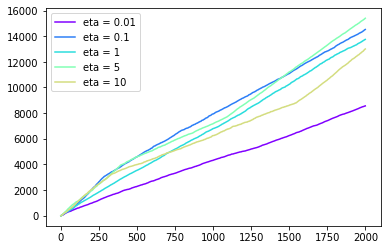

In [ ]:
T = 2000
d = 6
ncosts = 3
cov = 20*np.eye(d)
#calculate adversary parameters
mu = np.zeros((d))
x = np.random.multivariate_normal(mu, cov, ncosts)
cs = np.zeros((ncosts, 1))
for i in range(ncosts):
    c = random.randint(1, 50)
    cs[i] = c
costs = np.hstack((cs, x))
ts = np.arange(T)
#set adversary
A = Adversary(costs)
color=cm.rainbow(np.linspace(0,1, 7))
#measuring varaiation with eta
etas = [0.01, 0.1 , 1 , 5, 10]
i = 0
for eta in etas:
    while True:
        try:
            regret = SCRIBBLE(T,d,ncosts,eta,A)
        except:
            #Algorithm sometimes has problem due to solver if so repeat
            continue
        else:
            plt.plot(ts, regret, label = "eta = " + str(eta) , c = color[i])
            break
    i = i+1
plt.legend()

Senstivity to Adversary parameters

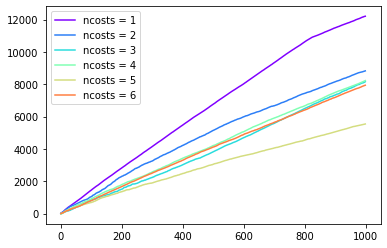

In [ ]:
T = 1000
d = 6
eta = 0.5
ncosts = 3
cov = 20*np.eye(d)
mu = np.zeros((d))
ts = np.arange(T)
color=cm.rainbow(np.linspace(0,1, 7))
ncosts = [ 1, 2, 3, 4, 5, 6]
#Measuring variation with ncost
for ncost in ncosts:
    #calculate adversary parameters for current value of ncosts 
    x = np.random.multivariate_normal(mu, cov, ncost)
    cs = np.zeros((ncost, 1))
    for i in range(ncost):
        c = random.randint(1, 50)
        cs[i] = c
    costs = np.hstack((cs, x))
    ts = np.arange(T)
    #initialize adversary
    A = Adversary(costs)
    tr = 0
    while True:
        try:
            tr = tr+1
            regret = SCRIBBLE(T,d,ncost,eta,A)
        except:
            continue
        else:
            plt.plot(ts, regret, label = "ncosts = " + str(ncost), c = color[i])
            break
plt.legend()

Comparison to Theoretical Bound

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


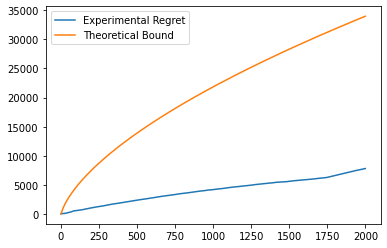

In [ ]:
T = 2000
d = 6
ncosts = 1
eta = 1
cov = 20*np.eye(d)
mu = np.zeros((d))
x = np.random.multivariate_normal(mu, cov, ncosts)
cs = np.zeros((ncosts, 1))
for i in range(ncosts):
    c = random.randint(1, 50)
    cs[i] = c
costs = np.hstack((cs, x))
ts = np.arange(T)
A = Adversary(costs)
ts = np.arange(T)
while True:
    try:
        regret = SCRIBBLE(T,d,ncosts,eta, A)
    except:
        continue
    else:
        plt.plot(ts, regret, label = "Experimental Regret" )
        break
#calculating the bound a small number is multiplied since it is O() which considers constants
bound = 100*np.multiply(np.power(ts, 1/2),np.log(ts))
plt.plot(ts, bound, label = "Theoretical Bound")
plt.legend()